In [1]:
import pandas as pd
import json
import seaborn as sb
import os
import matplotlib.pyplot as plt

# Metrics
Plot WER and CER for baseline, mono and aug models using Contextual Biasing

In [2]:
json_agg_filepath = 'C:\projects\malachor5\data\whisper-large.json'
with open(json_agg_filepath, encoding='utf8') as f:
    json_agg = json.load(f)
len(json_agg), json_agg[0].keys()

(3,
 dict_keys(['experiment_name', 'experiment_path', 'base_checkpoint', 'executions', 'train_data', 'train_events', 'test_data', 'eval_data']))

In [26]:
events = []
for experiment in json_agg:
    for eval_run in experiment['eval_data']:
        for event in eval_run['events']:
            events.append({
                'experiment_name': experiment['experiment_name'],
                'base_checkpoint': experiment['base_checkpoint'],
                'tag': event['tag'],
                'value': event['value'],
                'prompt_file': eval_run['prompt_file'] or 'None',
                'language': eval_run['language']
            })
    for test_run in experiment['test_data']:
        for event in test_run['events']:
            events.append({
                'experiment_name': experiment['experiment_name'],
                'base_checkpoint': experiment['base_checkpoint'],
                'tag': event['tag'],
                'value': event['value'],
                'prompt_file': test_run['prompt_file'] or 'None',
                'language': test_run['language']
            })
df = pd.DataFrame(events)
df.head()

,experiment_name,base_checkpoint,tag,value,prompt_file,language
0,whisper-large-tira-aug-LoRA,/home/mjsimmons/models/whisper-large-tira-aug-...,eval_loss,3.219259,/home/mjsimmons/datasets/tira_eval/prompts/pro...,None
1,whisper-large-tira-aug-LoRA,/home/mjsimmons/models/whisper-large-tira-aug-...,eval_model_preparation_time,0.0111,/home/mjsimmons/datasets/tira_eval/prompts/pro...,None
2,whisper-large-tira-aug-LoRA,/home/mjsimmons/models/whisper-large-tira-aug-...,eval_wer,0.640342,/home/mjsimmons/datasets/tira_eval/prompts/pro...,None
3,whisper-large-tira-aug-LoRA,/home/mjsimmons/models/whisper-large-tira-aug-...,eval_cer,0.504976,/home/mjsimmons/datasets/tira_eval/prompts/pro...,None
4,whisper-large-tira-aug-LoRA,/home/mjsimmons/models/whisper-large-tira-aug-...,eval_labels,"[Okay ""squirrel"" in Tira is uh... it's ŋòɽón...",/home/mjsimmons/datasets/tira_eval/prompts/pro...,None


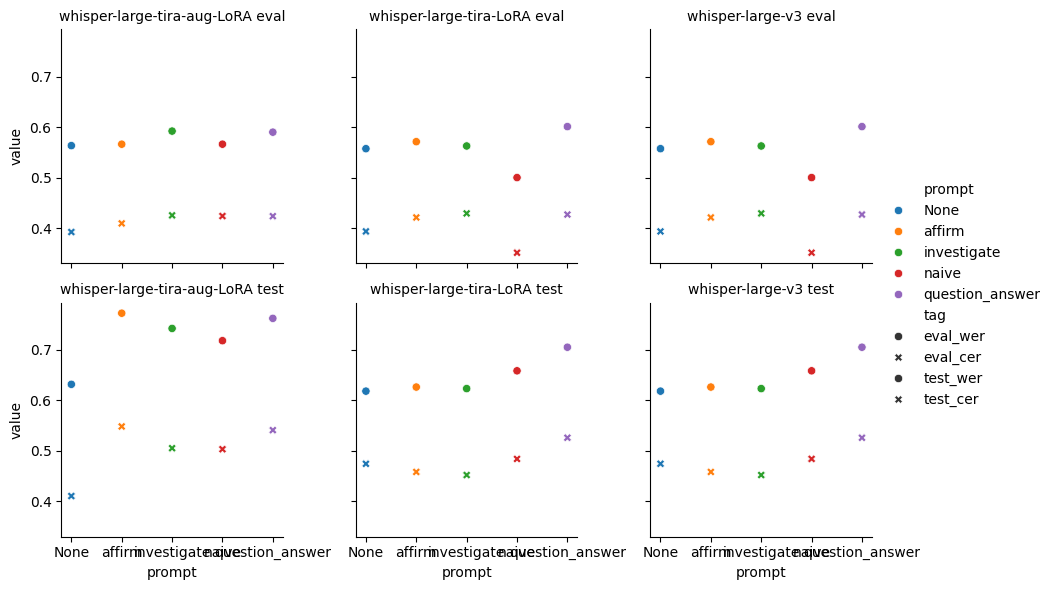

In [30]:
wer_cer_mask = df['tag'].str.contains('wer') | df['tag'].str.contains('cer')
df['split']='eval'
df.loc[df['tag'].str.contains('test'), 'split']='test'
en_mask = df['language']=='en'
df['prompt'] = df['prompt_file'].apply(os.path.basename).str.replace('.json', '').str.replace('prompt_', '')

g=sb.FacetGrid(df[wer_cer_mask&en_mask], col='experiment_name', row='split')
g.map_dataframe(
    sb.scatterplot,
    x='prompt',
    y='value',
    hue='prompt',
    style='tag',
)
g.set_titles("{col_name} {row_name}")
g.add_legend()
plt.show()

# Predictions
Make a csv file containing predictions across all runs

In [43]:
predictions = []
for experiment in json_agg:
    for eval_run in experiment['eval_data']:
        run_labels = None
        run_preds = None
        for event in eval_run['events']:
            if run_labels and run_preds:
                break
            elif not run_labels and 'labels' in event['tag']:
                run_labels = event['value']
            elif not run_preds and 'preds' in event['tag']:
                run_preds = event['value']
        run_rows = [{
            'experiment_name': experiment['experiment_name'],
            'base_checkpoint': os.path.basename(experiment['base_checkpoint']),
            'prompt_file': os.path.basename(eval_run['prompt_file']) if eval_run['prompt_file'] else 'None',
            'language': eval_run['language'],
            'pred': pred,
            'label': label,
            'split': 'eval',
        } for label, pred in zip(run_labels, run_preds)]
        predictions.extend(run_rows)

    for test_run in experiment['test_data']:
        run_labels = None
        run_preds = None
        for event in test_run['events']:
            if run_labels and run_preds:
                break
            elif not run_labels and 'labels' in event['tag']:
                run_labels = event['value']
            elif not run_preds and 'preds' in event['tag']:
                run_preds = event['value']
        run_rows = [{
            'experiment_name': experiment['experiment_name'],
            'base_checkpoint': os.path.basename(experiment['base_checkpoint']),
            'prompt_file': os.path.basename(test_run['prompt_file']) if test_run['prompt_file'] else 'None',
            'language': test_run['language'],
            'pred': pred,
            'label': label,
            'split': 'eval',
        } for label, pred in zip(run_labels, run_preds)]
        predictions.extend(run_rows)
pred_df = pd.DataFrame(predictions)
pred_df.head()

,experiment_name,base_checkpoint,prompt_file,language,pred,label,split
0,whisper-large-tira-aug-LoRA,whisper-large-tira-aug-LoRA,prompt_affirm.json,None,"Okay, skill in Tira is... It's gone. All done....","Okay ""squirrel"" in Tira is uh... it's ŋòɽón ...",eval
1,whisper-large-tira-aug-LoRA,whisper-large-tira-aug-LoRA,prompt_affirm.json,None,I think it's two times right? One which is brown,"For good? Yeah, I think squirrel is good, actu...",eval
2,whisper-large-tira-aug-LoRA,whisper-large-tira-aug-LoRA,prompt_affirm.json,None,"And then there's another one that looks, I me...","And then there's another one that looks, I mea...",eval
3,whisper-large-tira-aug-LoRA,whisper-large-tira-aug-LoRA,prompt_affirm.json,None,"So, can you say the... So, the word for the br...","So you can say the... So, ŋ̀cɔ́lɔ̀, the word f...",eval
4,whisper-large-tira-aug-LoRA,whisper-large-tira-aug-LoRA,prompt_affirm.json,None,"Next on the list is... Oh, sorry. What's the t...","Next on the list is... Hang on, hang on. What'...",eval


In [44]:
pred_path = 'eval_contextual_bias_apr25_predictions.xlsx'
pred_df.to_excel(pred_path)